## 3. (20%) Deep Learning - handwritten digit recognition

It is available in text form and contains 1593 handwritten digits from 80 persons. The images are 16 × 16 pixels square box and in black and white format. (teacher took 15 samples for validation and you only see 1578 samples)

### 3-(a) (15%) 
For BPN (or CNN if you prefer), try to investigate the effects of changing “PARAMETERS” such as learning rates, momentum, # of hidden/convolutional layers, dropout rate, etc. Show the numerical results and “DIAGRAM” from different perspectives (e.g., MSE/accuracy, F1 score, convergence time, error of training data, error of testing data, etc.). Please show all your work in detail, in particular, you “MAY” need to design your experiments with different parameters systematically.

Ans: 我的訓練結果如下
- 一開始調整 lr 和 decay並觀察loss，當模型loss能穩定下降便固定此組param。
    - lr: 0.01, weight_decay: 1e-3, batch_size = 15。
- 原先將 Kernal 數設為 1，沒想到digit 5沒有被預測出來，才發現是Kernal數不足。
    - Saving model (epoch =   98, train loss = 1.7298, dev loss = 1.7056, train acc = 0.74)
- 當我將 Kernel 數調整為 5，模型便能學辨識到每種，只是digit 7的FP rate較高，會將1 3當成7來預測。
    - Saving model (epoch =   66, train loss = 1.6112, dev loss = 1.5918, train acc = 0.85)
- 統一把 Kernel size 調整為 3，成效又更好了。
    - Saving model (epoch =   35, train loss = 1.5855, dev loss = 1.5847, train acc = 0.88)

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Imports
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# For data preprocess
import pandas as pd
import numpy as np
import csv
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

myseed = 2077  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0., 3.)
    plt.xlabel('Training steps')
    plt.ylabel('Cross entropy loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(input_set, model, device):
    ''' Plot prediction of your DNN 
    https://stackoverflow.com/questions/33379261/how-can-i-have-a-bar-next-to-python-seaborn-heatmap-which-shows-the-summation-of '''
    # see the result of training set
    preds, labels = test(input_set, model, device, with_label=True)
    cf_matrix = confusion_matrix(labels, preds)
    # print(cf_matrix)
    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot2grid((10,10), (0,0), colspan=9, rowspan=9)
    ax2 = plt.subplot2grid((10,10), (9,0), colspan=9, rowspan=1)
    ax3 = plt.subplot2grid((10,10), (0,9), colspan=1, rowspan=9)

    sns.heatmap(cf_matrix, ax=ax1, annot=True, fmt='g',  cmap="YlGnBu", linecolor='b', cbar = False)

    ax1.set(ylabel="True label")
    ax1.xaxis.tick_top()
    sns.heatmap((pd.DataFrame(cf_matrix.sum(axis=0))).transpose(), ax=ax2,  annot=True, fmt='g', cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(pd.DataFrame(cf_matrix.sum(axis=1)), ax=ax3,  annot=True, fmt='g', cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
    ax2.set(xlabel="Prediction")
    

### Data load & prepare

X_train shape: (1341, 1, 16, 16)
y_train shape: (1341, 10)
X_dev   shape: (237, 1, 16, 16)
y_dev   shape: (237, 10)
X_pred shape: (15, 1, 16, 16)


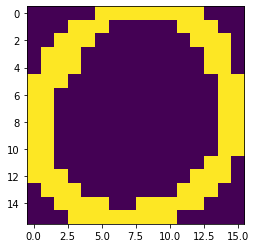

In [4]:
# Data load & prepare
path = "./MDS_Assignment3_DRtraining.xlsx"
df_train = pd.read_excel(path, sheet_name="training", index_col=0)
path = "./MDS_Assignment3_DRpredict.xlsx"
df_pred = pd.read_excel(path, sheet_name="Predict", index_col=0)

X_train = df_train.iloc[:,0:256].values
y_train = df_train.iloc[:,256:].values
X_train = X_train.reshape(-1, 1, 16, 16) # channel是1

# train valid split
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=2042)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_dev   shape:", X_dev.shape)
print("y_dev   shape:", y_dev.shape)

X_pred = df_pred.iloc[:,0:256].values
X_pred = X_pred.reshape(-1, 1, 16, 16)
print("X_pred shape:", X_pred.shape)

plt.imshow(X_train[1].reshape(16,16))

class CnnDataset(Dataset):
    ''' Dataset for our pre-processed dataset '''
    def __init__(self, data, target=None, mode='train'):
        self.mode = mode

        # Read data
        assert(mode in ['train','dev','test'])
        if mode == 'train':
            self.data = data
            self.target = target
            assert(len(self.data) == len(self.target))
        elif mode == 'dev':
            self.data = data
            self.target = target
            assert(len(self.data) == len(self.target))
        else:
            self.data = data
        
        # Get the length, dimansion of dataset
        self.dim = self.data.shape[1:]
        print('Finished reading the {} set of CNN Dataset ({} samples found, input dim = {})'
              .format(mode, len(self.data), self.dim))

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Returns one sample for the index at a time
        if self.mode in ['train', 'dev']: # For training
            return torch.FloatTensor(self.data[index]), torch.FloatTensor(self.target[index])
        else:                             # For testing (no target)
            return torch.FloatTensor(self.data[index])

def dataloader(mode, data, target, batch_size=15, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = CnnDataset(data, target, mode)  # Construct dataset
    return DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader

In [5]:
# load test
tr_set = dataloader('train', X_train, y_train)
dv_set = dataloader('dev',   X_dev, y_dev )
tt_set = dataloader('test',  X_pred, None )

Finished reading the train set of CNN Dataset (1341 samples found, input dim = (1, 16, 16))
Finished reading the dev set of CNN Dataset (237 samples found, input dim = (1, 16, 16))
Finished reading the test set of CNN Dataset (15 samples found, input dim = (1, 16, 16))


In [46]:
# build model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # torch.nn.BatchNorm2d(num_features): C from an expected input of size (N, C, H, W)
        # output shape = ((W-F+2*P )/S)+1

        # input image size: [1, 16, 16] for [channels, width, height]
        # output label: 10 kinds of digit
        self.numOfKernal = 5
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, self.numOfKernal, kernel_size=3, stride=1, padding=0), # [1, 14, 14]
            nn.BatchNorm2d(self.numOfKernal),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2, 1),      # [none]

            nn.Conv2d(self.numOfKernal, self.numOfKernal, kernel_size=3, stride=1, padding=0), # [1, 12, 12]
            nn.BatchNorm2d(self.numOfKernal),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),      # [none]
            nn.Dropout(p=0.3),

            nn.Conv2d(self.numOfKernal, self.numOfKernal, 3, 1, 0), # [1, 10, 10]
            nn.BatchNorm2d(self.numOfKernal),
            nn.ReLU(),
            # nn.MaxPool2d(2, 1, 0),      # [none]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(self.numOfKernal*10*10, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

        # CrossEntropyLoss for classification
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # input (x): [batch_size, 1, 16, 16]
        # output: [batch_size, 10]
        
        x = self.cnn_layers(x) # Extract features by convolutional layers.
        # print('cnn out shape:', x.shape)
        x = x.flatten(1)       # The extracted feature map must be flatten before going to fully-connected layers.
        x = self.fc_layers(x).softmax(dim=1)  # The features are transformed by fully-connected layers to obtain the final logits.
        # print('fc  out shape:', x.shape)
        return x

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

#### Training test validation function
loss 其實是 cross entropy 不是 mse 懶得改變數名稱了

In [38]:
def train(tr_set, dv_set, model, config, device):

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    # Setup lr_scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,20,30,50], gamma=config['lr_gamma'])

    min_mse = 2000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss per batch
    loss_epoch  = {'train': [], 'dev': []}      # for recording training loss per epoch
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        correct = 0
        total_loss = 0                          # zero train loss
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            pred_class = pred.argmax(dim=1)
            true_class = y.argmax(dim=1)
            correct += pred_class.eq(true_class).sum().item()     # count of correct guess
            total_loss += mse_loss.detach().cpu().item() * len(x) # accumulate train loss
            loss_record['train'].append(mse_loss.detach().cpu().item())
        total_loss = total_loss / len(tr_set.dataset)              # compute averaged loss
        acc = correct / len(tr_set.dataset)

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, train loss = {:.4f}, dev loss = {:.4f}, train acc = {:.2f})'
                .format(epoch + 1, total_loss, min_mse, acc))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # print('latest model (epoch = {:4d}, train loss = {:.4f}, dev loss = {:.4f})'
            #     .format(epoch + 1, total_loss, dev_mse))
            early_stop_cnt += 1

        scheduler.step() # lr decay here
        epoch += 1
        loss_record['dev'].append(dev_mse)
        loss_epoch['train'].append(total_loss)
        loss_epoch['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record, loss_epoch

def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model, device, with_label=False):
    model.eval()                                # set model to evalutation mode
    preds = []
    true_labels = []
    if with_label:
        for x, y in tt_set: 
            x = x.to(device)                        
            with torch.no_grad():                   
                pred = model(x)                     
                preds.append(pred.detach().cpu())   
            true_labels.append(y)
        preds = torch.cat(preds, dim=0).argmax(dim=1) 
        true_labels = torch.cat(true_labels, dim=0).argmax(dim=1) 
        return preds.numpy(), true_labels.numpy()
    else:  
        for x in tt_set:                            # iterate through the dataloader
            x = x.to(device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                   # disable gradient calculation
                pred = model(x)                     # forward pass (compute output)
                preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).argmax(dim=1)     # concatenate all predictions and convert to a numpy array
    return preds.numpy()

#### Fit dataset

In [39]:
# Setup Hyper-parameters
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 15,                # mini-batch size for dataloader
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.01,                # learning rate
        'weight_decay': 1e-3         # weight decay (L2 penalty)
    },
    'lr_gamma': 0.1,                 # learning rate decay
    'early_stop': 50,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'R10725012_呂晟維_cnn.pth',  # your model will be saved here
    'save_path_rnn': 'R10725012_呂晟維_rnn.pth'
}

In [40]:
# device = get_device()
# model = ConvNet().to(device) # Construct model and move to device
# for x, y in tr_set:                     # iterate through the dataloader
#     # optimizer.zero_grad()               # set gradient to zero
#     print(x.shape, y.shape)
#     x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
#     pred = model(x)                     # forward pass (compute output)
#     pred_class = pred.argmax(dim=1)
#     true_class = y.argmax(dim=1)
#     correct = pred_class.eq(true_class).sum().item()
#     # print(pred_class, true_class, correct)
#     # print(pred)
#     # loss = model.cal_loss(pred, y)
#     # print(loss)
#     break

In [47]:
# Load data and model
tr_set = dataloader('train', X_train, y_train, config['batch_size'])
dv_set = dataloader('dev',   X_dev, y_dev, config['batch_size'])
tt_set = dataloader('test',  X_pred, None, config['batch_size'])
model = ConvNet().to(device) # Construct model and move to device

Finished reading the train set of CNN Dataset (1341 samples found, input dim = (1, 16, 16))
Finished reading the dev set of CNN Dataset (237 samples found, input dim = (1, 16, 16))
Finished reading the test set of CNN Dataset (15 samples found, input dim = (1, 16, 16))


In [48]:
# Start training
model_loss, model_loss_record, model_loss_epoch = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, train loss = 2.1185, dev loss = 1.9591, train acc = 0.33)
Saving model (epoch =    3, train loss = 1.8436, dev loss = 1.8527, train acc = 0.61)
Saving model (epoch =    4, train loss = 1.8353, dev loss = 1.7091, train acc = 0.62)
Saving model (epoch =    6, train loss = 1.7254, dev loss = 1.6846, train acc = 0.73)
Saving model (epoch =    7, train loss = 1.7204, dev loss = 1.6674, train acc = 0.74)
Saving model (epoch =    8, train loss = 1.6834, dev loss = 1.6346, train acc = 0.78)
Saving model (epoch =    9, train loss = 1.6794, dev loss = 1.6287, train acc = 0.78)
Saving model (epoch =   10, train loss = 1.6544, dev loss = 1.5972, train acc = 0.81)
Saving model (epoch =   13, train loss = 1.6094, dev loss = 1.5928, train acc = 0.85)
Saving model (epoch =   14, train loss = 1.6047, dev loss = 1.5926, train acc = 0.86)
Saving model (epoch =   15, train loss = 1.5991, dev loss = 1.5918, train acc = 0.86)
Saving model (epoch =   16, train loss = 1.6038, dev l

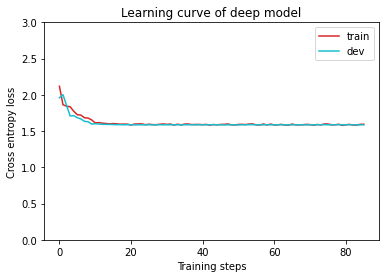

In [49]:
plot_learning_curve(model_loss_epoch, title='deep model')

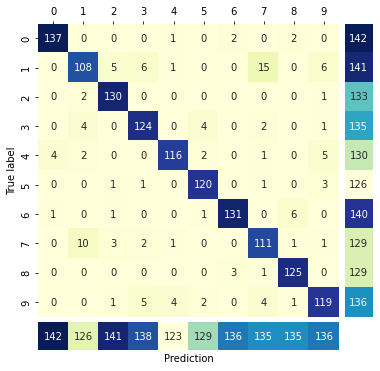

In [50]:
# see the result of training set
plot_pred(tr_set, model, device)

In [51]:
# see the result of validation set
preds, labels = test(dv_set, model, device, with_label=True)
print(preds.shape, labels[:3])

(237,) [8 6 6]


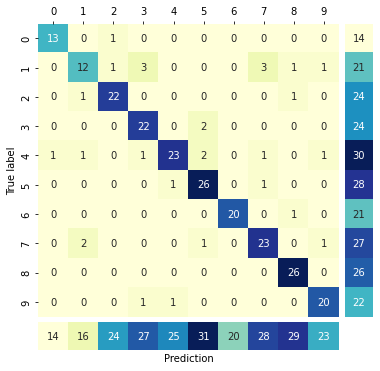

In [52]:
# preds, labels = test(dv_set, model, device, with_label=True)
plot_pred(dv_set, model, device)

### 3-(b) (5%) 
Please predict the digit No.1579 to No.1593 (data source: MDS_Assignment3_ DRpredict.xlsx) using your best established BPN/CNN model in (a) and fill out the following table.

預測15筆測試資料。  
ref: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy

In [53]:
preds = test(tt_set, model, device)
print('the prediction of hand written digit is:', preds)

the prediction of hand written digit is: [4 0 5 0 5 4 5 0 2 5 7 0 2 5 7]


In [54]:
submit_matrix = []
start = 1579
for i,v in enumerate(preds):
    submit_matrix.append([start+i, v])
pd.DataFrame(submit_matrix, columns=['No.','Digit Number (0 9) you predict'])

,No.,Digit Number (0 9) you predict
0,1579,4
1,1580,0
2,1581,5
3,1582,0
4,1583,5
5,1584,4
6,1585,5
7,1586,0
8,1587,2
9,1588,5


In [55]:
onehot_preds = np.zeros((preds.size, preds.max() + 1))
onehot_preds[np.arange(preds.size), preds] = 1
onehot_preds

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])